In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import os
import glob
import lightkurve as lk

In [2]:
filenames = []

print(glob.glob(os.path.join("TFRecords/", "train*")))

rootdir = "TFRecords/"
for path in Path(rootdir).glob('train*'):
    filenames.append(path)
filenames

['TFRecords/train-00004-of-00008', 'TFRecords/train-00002-of-00008', 'TFRecords/train-00006-of-00008', 'TFRecords/train-00007-of-00008', 'TFRecords/train-00003-of-00008', 'TFRecords/train-00005-of-00008', 'TFRecords/train-00001-of-00008', 'TFRecords/train-00000-of-00008']


[PosixPath('TFRecords/train-00004-of-00008'),
 PosixPath('TFRecords/train-00002-of-00008'),
 PosixPath('TFRecords/train-00006-of-00008'),
 PosixPath('TFRecords/train-00007-of-00008'),
 PosixPath('TFRecords/train-00003-of-00008'),
 PosixPath('TFRecords/train-00005-of-00008'),
 PosixPath('TFRecords/train-00001-of-00008'),
 PosixPath('TFRecords/train-00000-of-00008')]

In [3]:
"""
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset
"""

'\nraw_dataset = tf.data.TFRecordDataset(filenames)\nraw_dataset\n'

In [4]:
"""
for raw_record in raw_dataset:
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(dict(example.features.feature).keys())
  print(len(example.features.feature['local_view'].float_list.value))
  local_view = np.array(ex.features.feature["local_view"].float_list.value)
  fig, axes = plt.subplots(1, 2, figsize=(20, 6))
  axes[1].plot(local_view, ".")
  plt.show()
"""

'\nfor raw_record in raw_dataset:\n  example = tf.train.Example()\n  example.ParseFromString(raw_record.numpy())\n  print(dict(example.features.feature).keys())\n  print(len(example.features.feature[\'local_view\'].float_list.value))\n  local_view = np.array(ex.features.feature["local_view"].float_list.value)\n  fig, axes = plt.subplots(1, 2, figsize=(20, 6))\n  axes[1].plot(local_view, ".")\n  plt.show()\n'

In [5]:
KEPLER_ID = 11442793  # Kepler-90
TFRECORD_DIR = "TFRecords/"

In [6]:
# Helper function to find the tf.Example corresponding to a particular TCE.
def find_tce(kepid, tce_plnt_num, filenames):
  for filename in filenames:
    for record in tf.compat.v1.python_io.tf_record_iterator(filename):
      ex = tf.train.Example.FromString(record)
      #print(len(ex.features.feature['local_view'].float_list.value))
      if (ex.features.feature["kepid"].int64_list.value[0] == kepid and
          ex.features.feature["tce_plnt_num"].int64_list.value[0] == tce_plnt_num):
        print("Found {}_{} in file {}".format(kepid, tce_plnt_num, filename))
        return ex
  raise ValueError("{}_{} not found in files: {}".format(kepid, tce_plnt_num, filenames))

In [7]:
# Find Kepler-90 g.
filenames = tf.io.gfile.glob(os.path.join(TFRECORD_DIR, "*"))
assert filenames, "No files found in {}".format(TFRECORD_DIR)
ex = find_tce(KEPLER_ID, 1, filenames)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Found 11442793_1 in file TFRecords/train-00003-of-00008


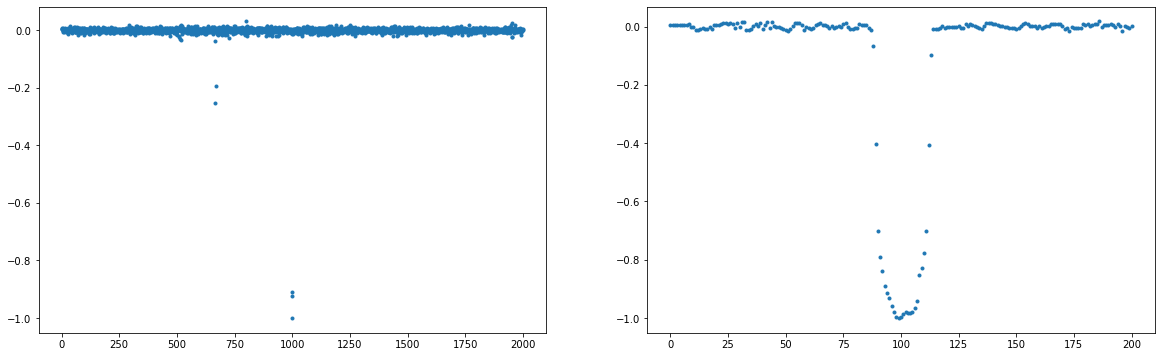

In [8]:
# Plot the global and local views.
global_view = np.array(ex.features.feature["global_view"].float_list.value)
local_view = np.array(ex.features.feature["local_view"].float_list.value)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(global_view, ".")
axes[1].plot(local_view, ".")
plt.show()

In [9]:
#print the feature names
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(dict(example.features.feature).keys())

2021-12-15 04:48:19.612166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 04:48:19.635378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 04:48:19.635785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 04:48:19.638196: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

dict_keys(['kepid', 'tce_prad', 'spline_bkspace', 'tce_plnt_num', 'tce_max_mult_ev', 'local_view', 'global_view', 'tce_period', 'tce_time0bk', 'tce_duration', 'av_pred_class', 'tce_model_snr', 'tce_depth', 'tce_impact', 'av_training_set'])


In [10]:
#reads TFRecord files and parses them into a long dataframe
def process(regex):
    filenames = []
    rootdir = "TFRecords/"
    for path in glob.glob(os.path.join(rootdir, regex)):
        filenames.append(path)
    
    # https://exoplanetarchive.ipac.caltech.edu/docs/API_tce_columns.html
    def pred_to_bool(pred):
        conv = []
        for prediction in pred:
            prediction = prediction.decode("utf-8") #convert from bytelist to string
            if(prediction == "PC"):
                conv.append(1)
            if(prediction == "AFP" or prediction == "NTP"):
                conv.append(0)
        return conv

    fluxes = []
    pred = []
    #create a long dataframe that is TSFresh compatable
    example_num = 0
    for filename in filenames:
        for record in tf.compat.v1.python_io.tf_record_iterator(filename):
            ex = tf.train.Example.FromString(record)
            local_view = np.array(ex.features.feature["local_view"].float_list.value[0:])

            #for time in range(len(local_view)):
            #    data = data.append({'id': example_num, 'time': time, 'FLUX': local_view[time]}, ignore_index=True)
            #10000% performace boost!!!!
            for time in range(len(local_view)):
                 fluxes.append([example_num, time, local_view[time]])
            
            lc = lk.LightCurve(time = np.arange(len(local_view)), flux= local_view)
            #lc.scatter()
            
            pred.append(pred_to_bool(ex.features.feature["av_pred_class"].bytes_list.value[0:]))
            example_num += 1
            if example_num%100 == 0:
                print(example_num)
    

    data = pd.DataFrame(fluxes, columns = ["id", "time", "FLUX"])
    return data, pred

In [11]:
train_data, train_y = process('train*')
test_data, test_y = process('test*')
val_data, val_y = process('val*')

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [12]:
print(train_data, test_data, val_data)

            id  time      FLUX
0            0     0  0.063849
1            0     1  0.072552
2            0     2  0.071125
3            0     3  0.053433
4            0     4  0.029606
...        ...   ...       ...
2530384  12588   196  1.022789
2530385  12588   197  0.738470
2530386  12588   198  0.440043
2530387  12588   199  0.320673
2530388  12588   200  0.085187

[2530389 rows x 3 columns]           id  time      FLUX
0          0     0  0.000000
1          0     1 -0.005629
2          0     2 -0.018762
3          0     3  0.002814
4          0     4  0.080675
...      ...   ...       ...
316369  1573   196  0.485656
316370  1573   197  0.594262
316371  1573   198  0.639344
316372  1573   199  0.774590
316373  1573   200  0.846311

[316374 rows x 3 columns]           id  time      FLUX
0          0     0  0.574089
1          0     1  0.728745
2          0     2  0.675304
3          0     3  0.620243
4          0     4  0.377328
...      ...   ...       ...
316369  1573   196 -0.

In [13]:
train_data.to_pickle("./Kepler-Train.pkl")
test_data.to_pickle("./Kepler-Test.pkl")
val_data.to_pickle("./Kepler-Val.pkl")

with open('Labels-Train.npy', 'wb') as f:
    np.save(f, np.array(train_y))
    
with open('Labels-Test.npy', 'wb') as f:
    np.save(f, np.array(test_y))
    
with open('Labels-Val.npy', 'wb') as f:
    np.save(f, np.array(val_y))